Pupil Core device timing
========================

`PupilCore().light_stamper(...)` stamps light stimuli with the timestamp associated with the first frame where a light becomes visible to the world camera. This timestamp is ultimately what gets used to extract pupil data and as a reference for calculating time-critical measures, such as constriction latency and time-to-peak constriction. The validity of any time-related measures therefore depends on Pupil Capture's ability to synchronise the clocks of the cameras on a Pupil Core headset, but how well does it handle this task? When we discovered that the near-infrared from STLAB's amber channel gets detected by both eye and world cameras, we realised that we could test it ourselves using the `.light_stamper(...)` method. The protocol basically involves putting the Pupil Core headset inside the integrating sphere and repeatedly flashing a bright orange light in a dark room. Prior to each flash, we instantiate a `.light_stamper(...)` for each of the cameras. This gives us the pupil timestamp where the light was detected for each camera, allowing us to check how well the data streams are synchronised.


Testing protocol
----------------

In [1]:
from time import sleep

from pyplr.stlab import SpectraTuneLab, pulse_protocol
from pyplr.pupil import PupilCore

# set up pupil
p = PupilCore()

# setup stlab and make spectrum with near-IR
d = SpectraTuneLab(password='83e47941d9e930f6')
spec = [0, 0, 0, 0, 0, 0, 0, 4095, 0, 0]
pulse_protocol(spec, 1000, '1s_near_IR_pulse')
d.load_video_file('1s_near_IR_pulse.dsf')

# trigger params
threshold = 10
timeout = 6.

# make annotations for each camera
world_annotation = p.new_annotation('LIGHT_ON_WORLD')
eye_0_annotation = p.new_annotation('LIGHT_ON_EYE_0')
eye_1_annotation = p.new_annotation('LIGHT_ON_EYE_1')

# start recording and wait 10 s
p.command('R pupil_core_camera_sync_tests')
sleep(5.)

# results
results = {'world': [],
           'eye_0': [],
           'eye_1': []}

# begin testing protocol
for i in range(50):
    # start light_stampers
    lst_world = p.light_stamper(
        world_annotation, threshold, timeout,
        topic='frame.world')
    lst_eye_0 = p.light_stamper(
        eye_0_annotation, threshold, timeout,
        topic='frame.eye.0')
    lst_eye_1 = p.light_stamper(
        eye_1_annotation, threshold, timeout, 
        topic='frame.eye.1')
    
    # wait 100 ms then flash light
    sleep(1.)
    d.play_video_file()
    
    sleep(timeout)
    
    results['world'].append(lst_world.result())
    results['eye_0'].append(lst_eye_0.result())
    results['eye_1'].append(lst_eye_1.result())

# wait for 5 s and stop recording
sleep(5.)   
p.command('r')

STLAB device setup complete...
"1s_near_IR_pulse.dsf" saved in the current working directory.
video file loaded...
Waiting for a light to stamp...
Waiting for a light to stamp...
Waiting for a light to stamp...
playing video file...
Light stamped on frame.eye.1 at 441592.275011
Light stamped on frame.world at 441592.22962
Light stamped on frame.eye.0 at 441592.284636
Waiting for a light to stamp...
Waiting for a light to stamp...
Waiting for a light to stamp...
playing video file...
Light stamped on frame.world at 441599.40408199996
Light stamped on frame.eye.1 at 441599.463925
Light stamped on frame.eye.0 at 441599.46389
Waiting for a light to stamp...
Waiting for a light to stamp...
Waiting for a light to stamp...
playing video file...
Light stamped on frame.world at 441606.587979
Light stamped on frame.eye.1 at 441606.64714799996
Light stamped on frame.eye.0 at 441606.651018


'OK'

Only three trials are printed above, but we actually performed the test for 50 trials. Looks like the world camera leads by about 60 ms, with eye cameras closely in sync with one another. 

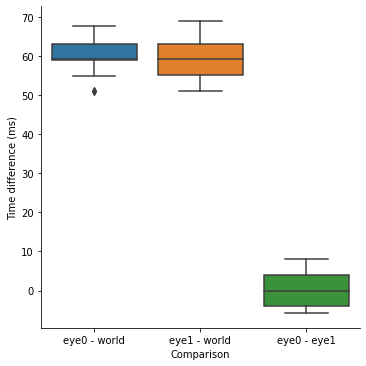

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for k in results.keys():
    results[k] = np.array([val[1] for val in results[k]])
    
df = pd.DataFrame(results)
diffs = (pd.DataFrame([(df.eye_0-df.world)*1000, 
                       (df.eye_1-df.world)*1000,
                       (df.eye_0-df.eye_1)*1000], 
                      index=['eye0 - world',
                             'eye1 - world',
                             'eye0 - eye1'])
           .T.melt(var_name='camdiff', value_name='timestamp'))
g = sns.catplot(x="camdiff", y="timestamp", data=diffs, kind='box')
(g.set(xlabel='Comparison',
       ylabel='Time difference (ms)'))

In [12]:
diffs.to_csv('win_sync_tests.csv')

MacOS
-----

Results

Windows
-------

Results

Implications for latency measures
---------------------------------

- biological implausability on mac
- Repeatability and possibility of correction
- etc.
